# Projet SD701 : Churn Prediction

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dexplot as dxp

# EDA 

* Train : contains the training churn data and has two columns :
    * msno : user id 
    * is churn : 1 = churn
* Test : contains the test churn data
* transactions : contains the transactions data for users, it contains 9 features : 
    * msno 
    * payment_method_id
    * payment_plan_days : The length of the membership plan (in days )
    * plan_list_price : 
    * actual_amount_paid : 
    * is_auto_renew : 
    * transaction_date : 
    * membership_expire_date : 
    * is_cancel : binary feature that show if the user cancelled the membership in this transaction
* Members : contains data about the users 
    * msno
    * gender
    * bd : Age 
    * city  
    * registred_via : the method of registration 
    * registration_init_time : the initial date of registration 
* user_logs : contains the daily activity of each user : number of songs that are listened of certain length.
    * msno
    * date 
    * num_25 : number of songs played less than 25% of the song length
    * num_50 : # of songs played between 25 and 50% of the song length
    * num_985 :# of songs played between 50 and 98.5% of the song length
    * num_100 : # of songs played over 98.5% of the song length
    * num_unq : # of songs played 
    * total_secs : total seconds played 

In [2]:
transactions = pd.read_csv("transactions_v2.csv")
members = pd.read_csv('members_v3.csv')
train = pd.read_csv("train_v2.csv")
test = pd.read_csv("sample_submission_v2.csv")
user_logs = pd.read_csv("user_logs_v2.csv")

## Train Dataset 

In [3]:
train.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [4]:
train.shape

(970960, 2)

In [5]:
# Checking for Null Values
train.isnull().values.any()

False

In [6]:
# Checking for Duplicated Value
train.duplicated().any()

False

In [7]:
train.is_churn.value_counts()

0    883630
1     87330
Name: is_churn, dtype: int64

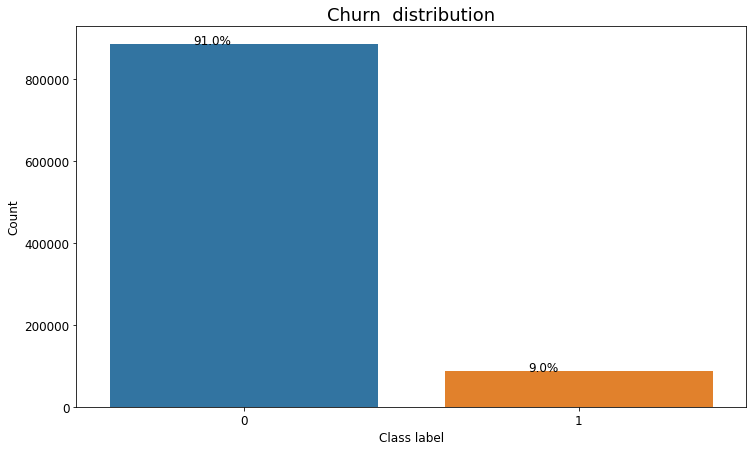

In [8]:
plt.figure(figsize=(12,7))
ax = sns.countplot(data=train, x='is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Class label', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/train.shape[0]), (p.get_x()+0.25, p.get_height()), size = 12)
plt.show()

The training dataset is unbalanced, there are a lot of non-churned users compared to those who churned. 

## Members 

In [9]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [10]:
members.shape

(6769473, 6)

In [11]:
# We merge the members dataset with the training to only keep the Data of users in the training dataset
train_members = pd.merge(train, members, on = "msno" , how = "left")
train_members.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,20131223.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,20131227.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,NaN,7.0,20140109.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,35.0,female,7.0,20140125.0


In [12]:
train_members.shape

(970960, 7)

In [13]:
train_members.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    970960 non-null  object 
 1   is_churn                970960 non-null  int64  
 2   city                    860967 non-null  float64
 3   bd                      860967 non-null  float64
 4   gender                  388905 non-null  object 
 5   registered_via          860967 non-null  float64
 6   registration_init_time  860967 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 59.3+ MB


In [14]:
train_members.duplicated("msno").sum()

0

In [15]:
train_members.isnull().sum()

msno                           0
is_churn                       0
city                      109993
bd                        109993
gender                    582055
registered_via            109993
registration_init_time    109993
dtype: int64

There are lot of null values in our dataset

* City

In [16]:
train_members['city'].value_counts()

1.0     442598
13.0     97136
5.0      70706
4.0      47227
15.0     43187
22.0     41991
6.0      26066
14.0     20013
12.0     11383
9.0       9526
11.0      9138
18.0      7792
8.0       7589
10.0      6470
17.0      5476
21.0      5199
3.0       5057
7.0       2652
16.0       944
20.0       677
19.0       140
Name: city, dtype: int64

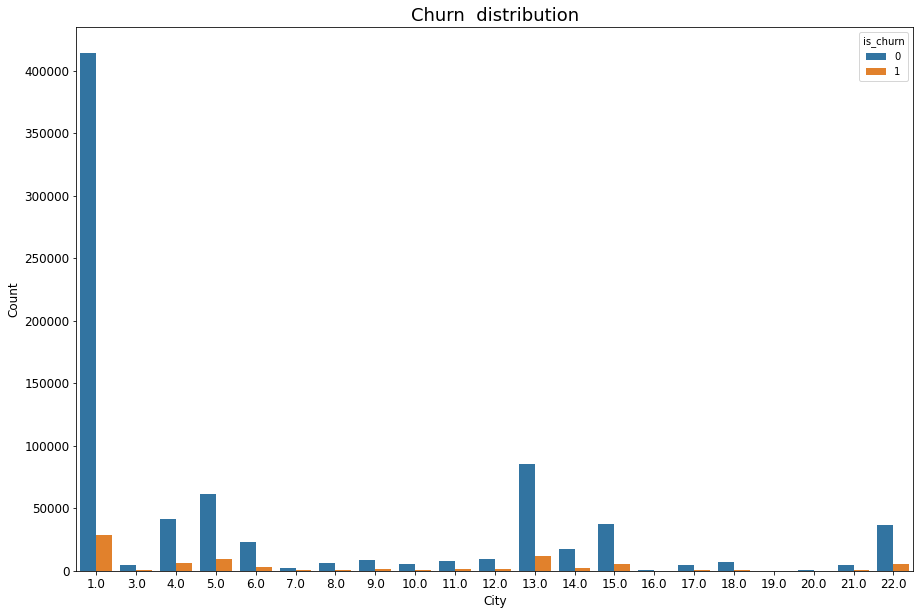

In [17]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_members, x='city', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('City', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

In [18]:
temp = pd.DataFrame(train_members.groupby("city")["is_churn"].agg(lambda x: x.eq(1).mean()))
temp.sort_values(by=['is_churn'],inplace=True, ascending=False)

In [19]:
temp

,is_churn
city,
21.0,0.147144
12.0,0.139243
8.0,0.134537
3.0,0.132885
10.0,0.132612
5.0,0.131997
4.0,0.129036
6.0,0.128827
15.0,0.128233


The city 21 has the highest rate of churn which 14.71% 

For the pre-processing, we could fill the nan values of city by a city with the code "0". 

In [20]:
train_members.city = train_members.city.fillna(0)

* Birthday

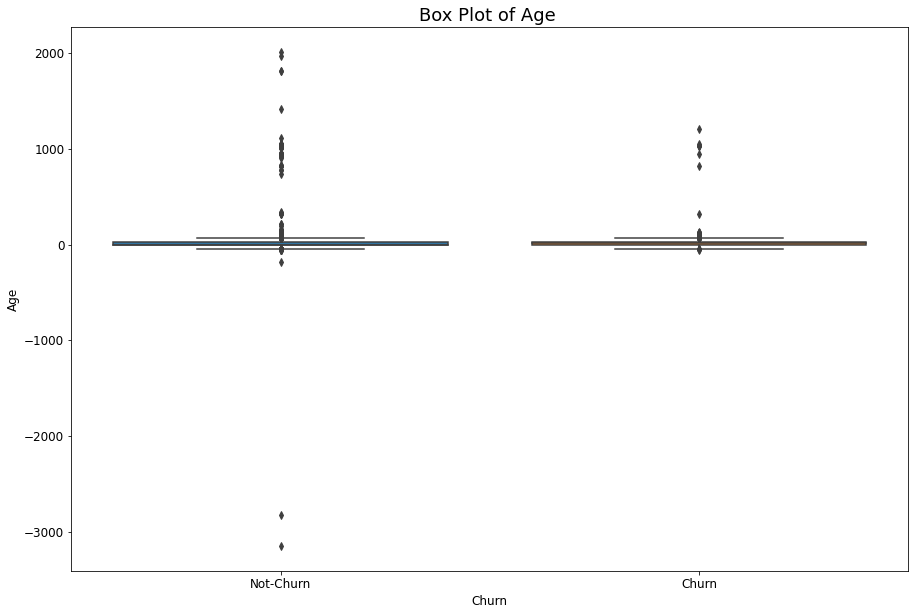

In [21]:
plt.figure(figsize=(15,10))
sns.boxplot(x='is_churn', y='bd', data=train_members)
plt.xticks([0, 1], ['Not-Churn', 'Churn'],size=12)
plt.yticks(size=12)
plt.xlabel('Churn', size=12)
plt.ylabel('Age', size=12)
plt.title('Box Plot of Age ', size=18)
plt.show()

There are lot of outliers in the age column. Thus, we will consider that it is an outlier outside the [5,95]

In [22]:
train_members['bd'] = train_members['bd'].apply(lambda x: x if (x < 71) and (x > 10) else np.nan)

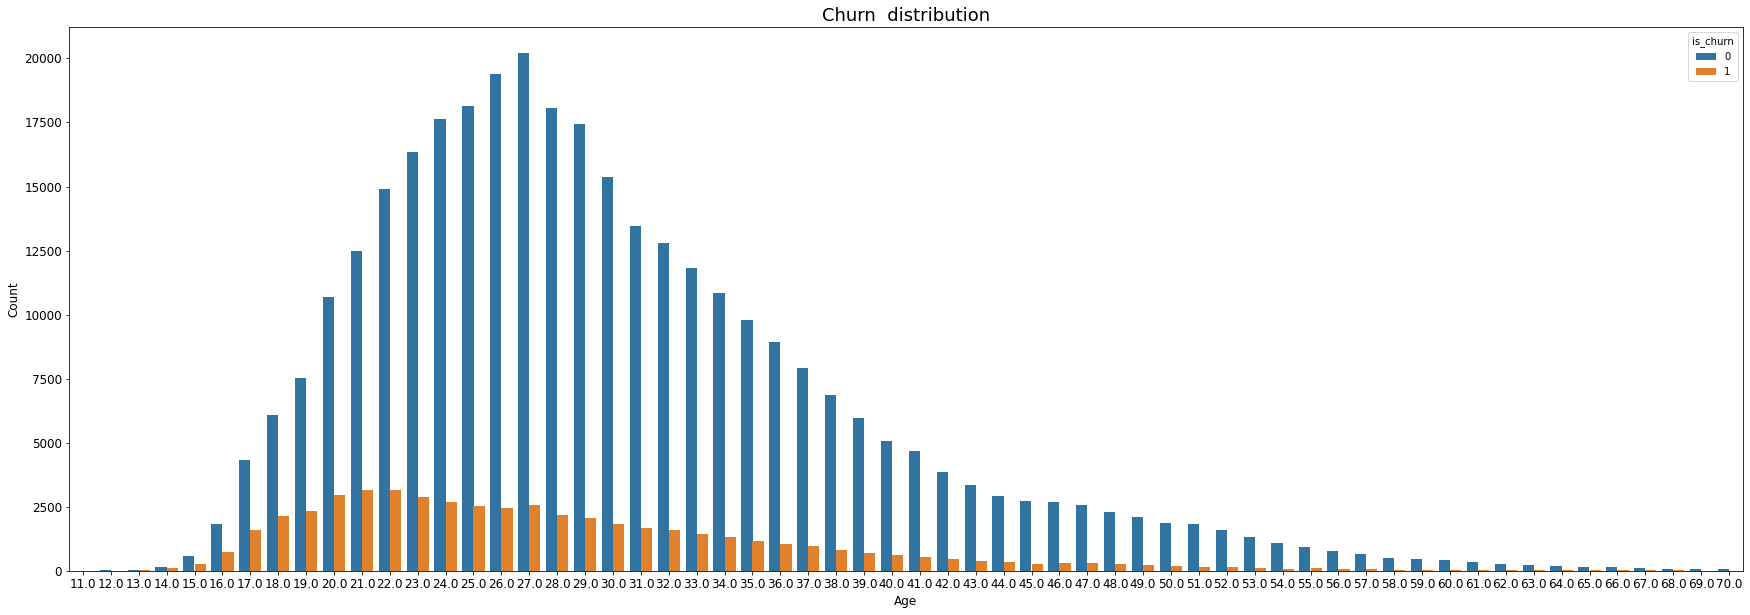

In [23]:
plt.figure(figsize=(30,10))
ax = sns.countplot(data=train_members, x='bd', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Age', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

We could easily observe that the Churn ratio is correlated to a "category" of age, thus we would categorize the age feature by adding a column "bd_range" which show to each range the age belongs

In [24]:
train_members.bd.max()

70.0

In [25]:
train_members.bd.quantile(0.1)

20.0

In [26]:
train_members.bd.quantile(0.25)

24.0

In [27]:
train_members.bd.quantile(0.75)

34.0

In [28]:
train_members.bd.quantile(0.9)

42.0

In [29]:
train_members.bd.quantile(0.999)

66.0

In [30]:
# Create a range of age 
bins= [10,20,24,34,42,66,70]
train_members['bd_range'] = np.digitize(train_members['bd'], bins, right=True)
train_members = train_members.drop('bd', axis = 1)

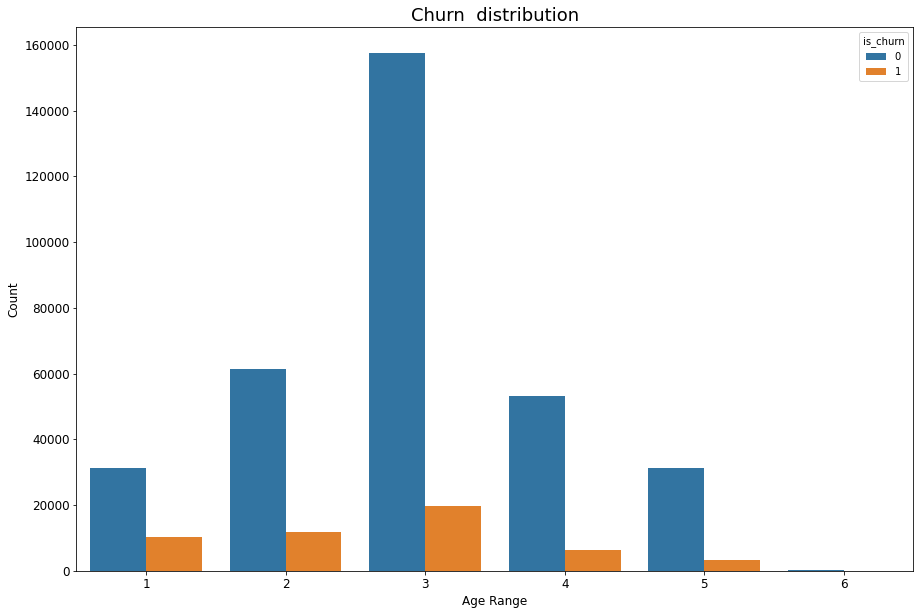

In [31]:
plt.figure(figsize=(15,10))
# We don't visualize the range 7 because it contains the outliers 
ax = sns.countplot(data=train_members[train_members["bd_range"]!=7], x='bd_range', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Age Range', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

* Gender 

In [32]:
train_members['gender'].unique()

array(['male', nan, 'female'], dtype=object)

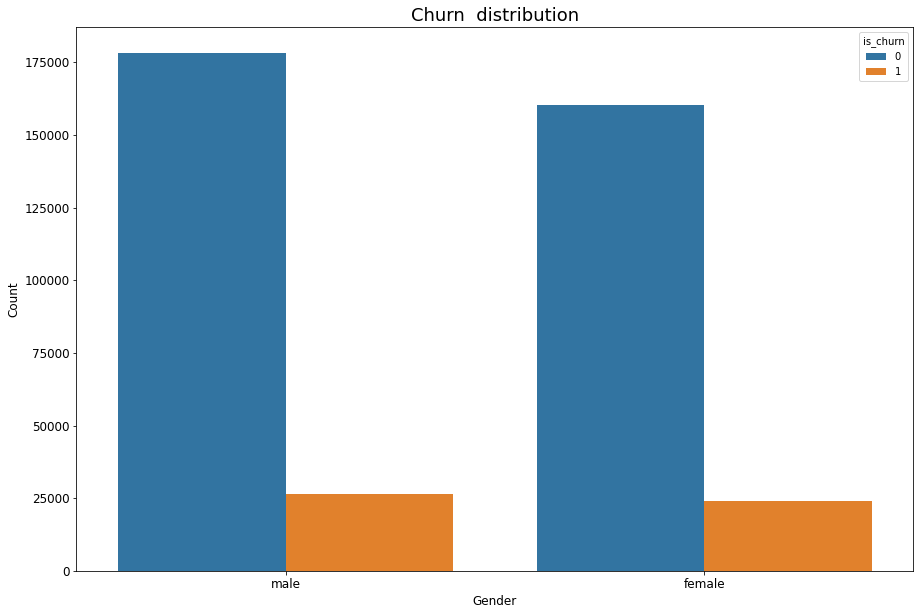

In [33]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_members, x='gender', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Gender', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

We will categorize the gender by assigning 1 for male and 2 for female, then fill nan values by 0

In [34]:
train_members.gender = train_members.gender.map({'male': 1, 'female': 2})
train_members.gender = train_members.gender.fillna(0)

* Registred via

In [35]:
train_members['registered_via'].unique()

array([ 3.,  7.,  9., nan,  4., 13.])

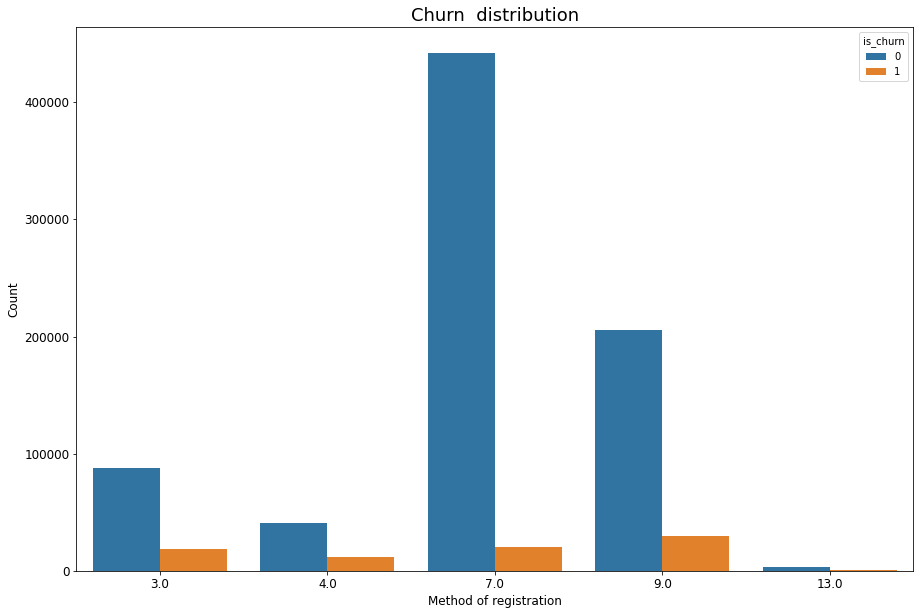

In [36]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_members, x='registered_via', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Method of registration', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

In [37]:
# Fill nan values by 0 
train_members.registered_via = train_members.registered_via.fillna(0)

* Registration_init_time

In [38]:
train_members['registration_init_time'] = pd.to_datetime(train_members['registration_init_time'], format='%Y%m%d')

In [39]:
train_members['year'] = train_members['registration_init_time'].dt.year.values
train_members['month'] = train_members['registration_init_time'].dt.month.values
train_members['weekday'] = train_members['registration_init_time'].dt.weekday.values

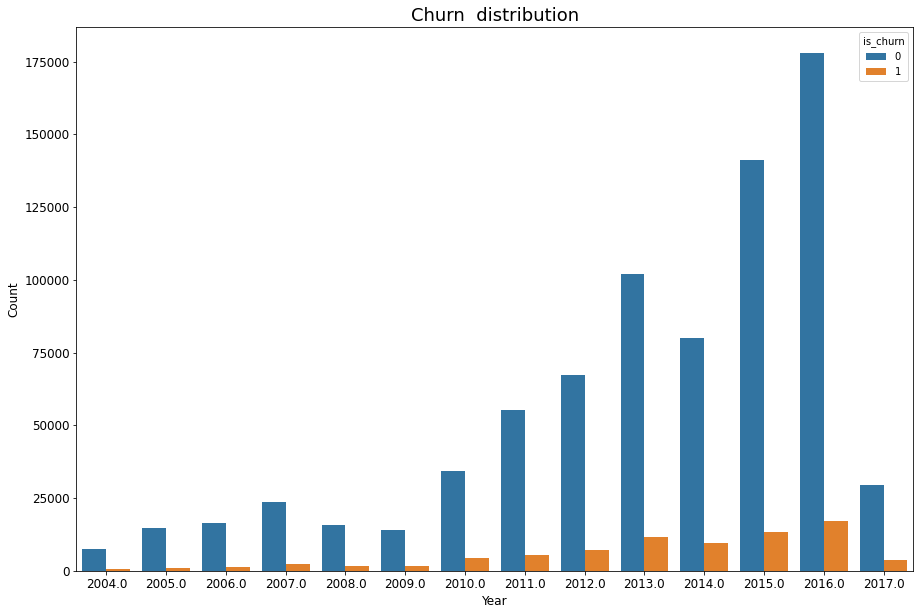

In [40]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_members, x='year', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Year', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

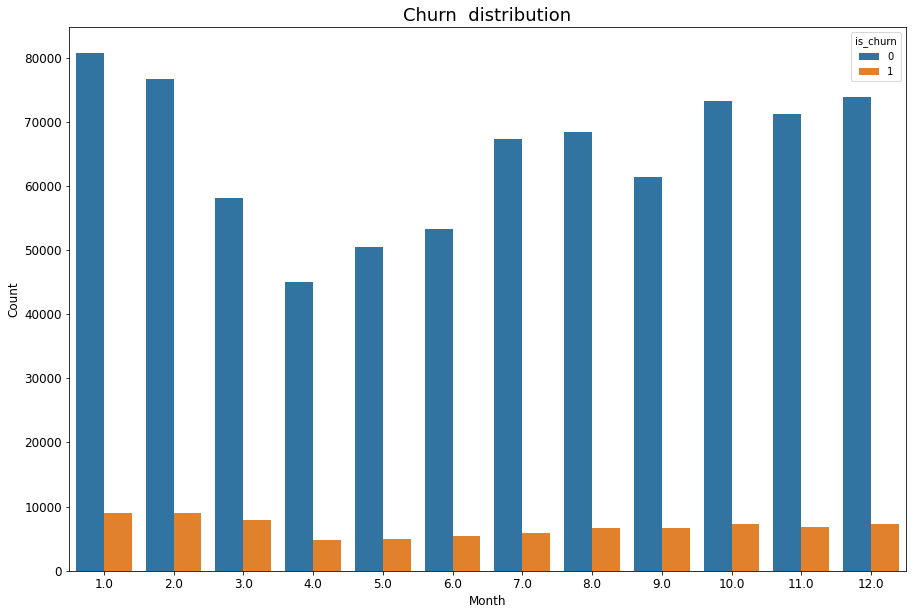

In [41]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_members, x='month', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Month', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

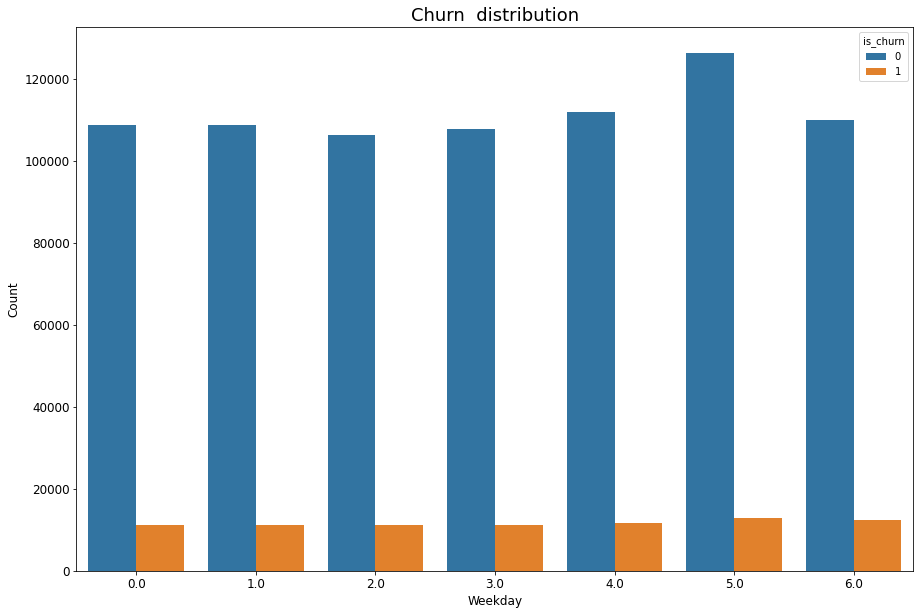

In [42]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_members, x='weekday', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Weekday', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

In [43]:
# Fill Nan values by mediane registration_init_time
dates = list(train_members.sort_values('registration_init_time')['registration_init_time'])
train_members.registration_init_time = train_members.registration_init_time.fillna(dates[len(dates)//2])

In [44]:
train_members['year'] = train_members['registration_init_time'].dt.year.values
train_members['month'] = train_members['registration_init_time'].dt.month.values
train_members['weekday'] = train_members['registration_init_time'].dt.weekday.values

## Transactions

In [45]:
transactions.shape

(1431009, 9)

In [46]:
transactions.duplicated("msno").sum()

233959

There are duplicates in transactions because 1 user can have multpile transactions

In [47]:
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'], format='%Y%m%d')

In [48]:
# We will keep the last transaction for each user 
transactions = transactions.sort_values(by=['transaction_date'])
transactions = transactions.drop_duplicates(subset=['msno'], keep='last')

In [49]:
# The shape of our frame before merging with the transactions df
train_members.shape

(970960, 10)

In [50]:
train_mt = pd.merge(train_members, transactions, on='msno', how='left')

In [51]:
# The shape of our frame after merging with the transactions df
train_mt.shape

(970960, 18)

In [52]:
train_mt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   msno                    970960 non-null  object        
 1   is_churn                970960 non-null  int64         
 2   city                    970960 non-null  float64       
 3   gender                  970960 non-null  float64       
 4   registered_via          970960 non-null  float64       
 5   registration_init_time  970960 non-null  datetime64[ns]
 6   bd_range                970960 non-null  int64         
 7   year                    970960 non-null  int64         
 8   month                   970960 non-null  int64         
 9   weekday                 970960 non-null  int64         
 10  payment_method_id       933578 non-null  float64       
 11  payment_plan_days       933578 non-null  float64       
 12  plan_list_price         933578

* Payment Method

In [53]:
train_mt['payment_method_id'].unique()

array([nan, 36., 15., 41., 40., 38., 32., 39., 37., 35., 20., 30., 29.,
       17., 16., 19., 13., 22., 34., 28., 10., 33., 31., 26., 27., 21.,
       12., 18., 23., 11.,  3., 14.,  6.,  8.])

Text(0.5, 1.0, 'Class label distribution')

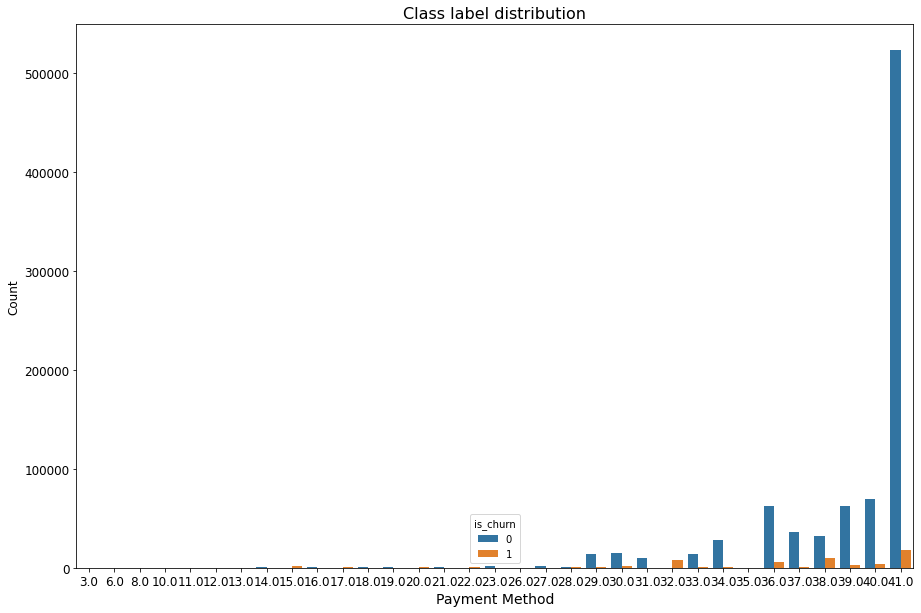

In [54]:
plt.figure(figsize=(15,10))
sns.countplot(data=train_mt, x='payment_method_id',hue='is_churn')
plt.xticks(size=12)
plt.xlabel('Payment Method', size=14)
plt.yticks(size=12)
plt.ylabel('Count', size=12)
plt.title('Class label distribution', size=16)

In [55]:
# Fill Nan Values by 0 
train_mt.payment_method_id = train_mt.payment_method_id.fillna(0)

* Payment Plan Days

In [56]:
train_mt['payment_plan_days'].unique()

array([ nan,  30.,  90., 410., 180., 195., 360., 240.,   7., 120., 100.,
       365.,  70.,  60.,   1., 200., 400., 395.,  80.,  10., 230., 450.,
        14., 110.,   3., 270., 415.,  35.,   0.])

<AxesSubplot:xlabel='is_churn', ylabel='payment_plan_days'>

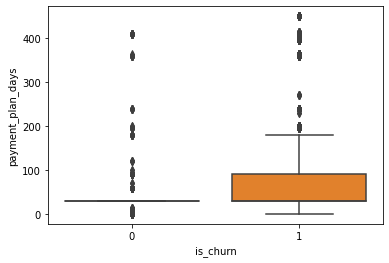

In [57]:
sns.boxplot(x='is_churn', y='payment_plan_days', data=train_mt)

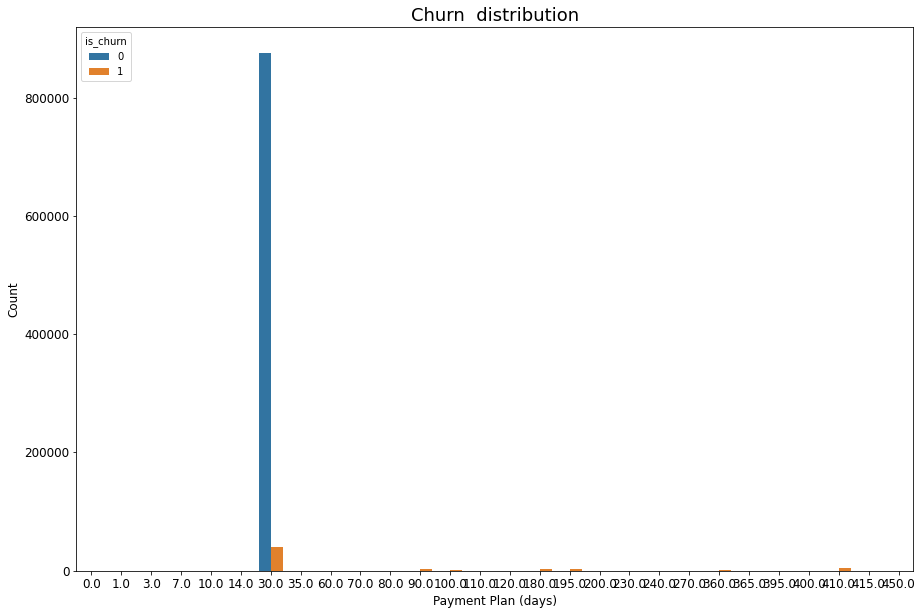

In [58]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_mt, x='payment_plan_days', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Payment Plan (days)', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

Majority of users purchase the 30 days subsription. Users who purchase another plan are more likely to churn.

To delete the outliers, we will only keep the plan days inferior to 30, the others will be replaced by the mediane plan days

In [59]:
train_mt['payment_plan_days'] = train_mt['payment_plan_days'].apply(lambda x: x if (x <= 30.0) else np.nan)

In [60]:
train_mt.payment_plan_days = train_mt.payment_plan_days.fillna(np.nanmedian(train_mt['payment_plan_days']))

In [61]:
# The new values 
train_mt.payment_plan_days.unique()

array([30.,  7.,  1., 10., 14.,  3.,  0.])

* Plan list price

In [62]:
train_mt['plan_list_price'].unique()

array([      nan, 1.800e+02, 3.000e+02, 1.490e+02, 9.900e+01, 1.788e+03,
       4.770e+02, 2.980e+02, 5.360e+02, 6.000e+02, 8.940e+02, 1.000e+02,
       1.200e+03, 4.470e+02, 0.000e+00, 4.800e+02, 1.290e+02, 3.500e+02,
       1.299e+03, 9.300e+02, 1.500e+02, 1.599e+03, 7.990e+02, 1.200e+02,
       4.000e+02, 3.500e+01, 1.150e+03, 4.500e+02, 1.190e+02, 1.000e+03,
       5.000e+02, 2.000e+03, 1.000e+00, 1.399e+03, 1.340e+02, 6.990e+02,
       1.260e+02, 2.100e+02, 5.960e+02, 1.310e+02, 2.650e+02, 7.000e+01,
       1.430e+02])

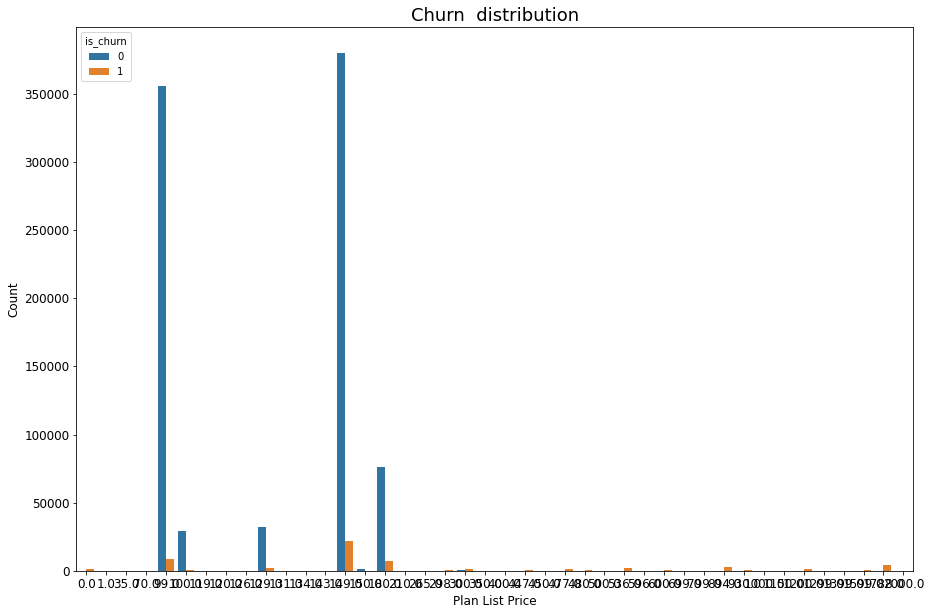

In [63]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_mt, x='plan_list_price', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Plan List Price', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

<AxesSubplot:xlabel='is_churn', ylabel='plan_list_price'>

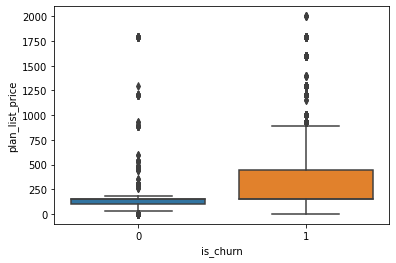

In [64]:
sns.boxplot(x='is_churn', y='plan_list_price', data=train_mt)

In [65]:
# Replace outliers by the mean value
mediane = np.nanmedian(train_mt['plan_list_price'])
quantile = train_mt.plan_list_price.quantile(0.95)
train_mt['plan_list_price'] = train_mt['plan_list_price'].apply(lambda x: x if (x <= quantile ) else mediane)

* Actual Amount Paid

In [66]:
train_mt['actual_amount_paid'].unique()

array([      nan, 1.800e+02, 3.000e+02, 1.490e+02, 9.900e+01, 1.788e+03,
       4.770e+02, 2.980e+02, 5.360e+02, 6.000e+02, 8.940e+02, 1.000e+02,
       1.200e+03, 4.470e+02, 0.000e+00, 4.800e+02, 1.290e+02, 3.500e+02,
       1.299e+03, 9.300e+02, 1.500e+02, 1.599e+03, 7.990e+02, 4.000e+02,
       3.500e+01, 1.150e+03, 4.500e+02, 1.190e+02, 1.200e+02, 1.000e+03,
       5.000e+02, 2.000e+03, 1.000e+00, 1.399e+03, 1.340e+02, 6.990e+02,
       1.270e+02, 2.100e+02, 5.960e+02, 1.310e+02, 2.650e+02, 7.000e+01,
       1.430e+02])

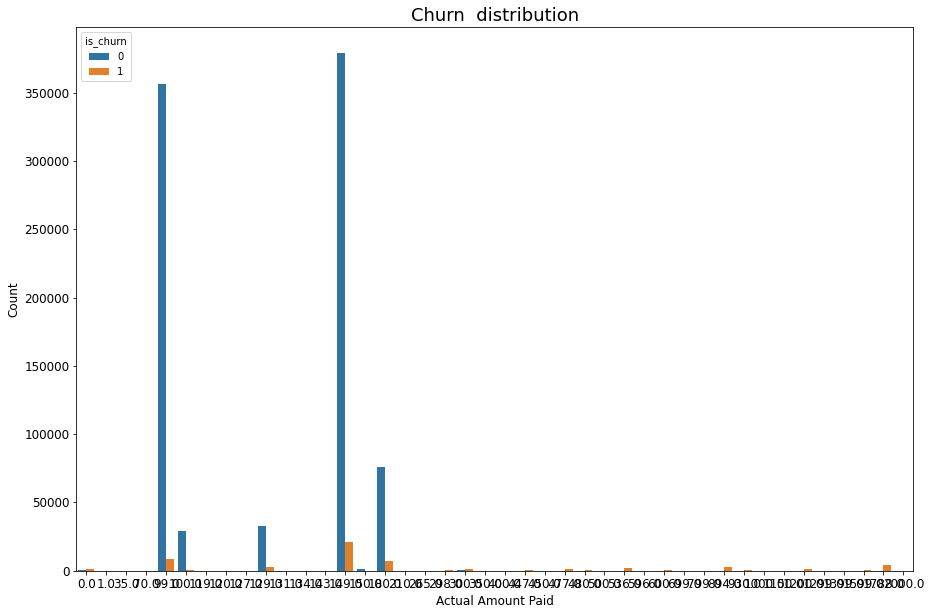

In [67]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_mt, x='actual_amount_paid', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Actual Amount Paid', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

<AxesSubplot:xlabel='is_churn', ylabel='actual_amount_paid'>

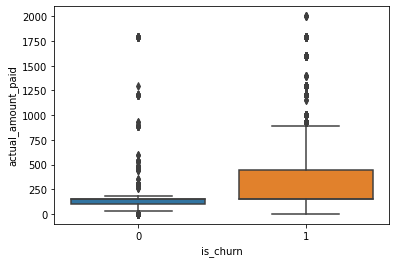

In [68]:
sns.boxplot(x='is_churn', y='actual_amount_paid', data=train_mt)

In [69]:
# Replace outliers by the mean actual_amount_paid 
mediane = np.nanmedian(train_mt['actual_amount_paid'])
quantile = train_mt.actual_amount_paid.quantile(0.95)
train_mt['actual_amount_paid'] = train_mt['actual_amount_paid'].apply(lambda x: x if (x <= quantile) else mediane)

* Is auto renew

In [70]:
train_mt['is_auto_renew'].unique()

array([nan,  0.,  1.])

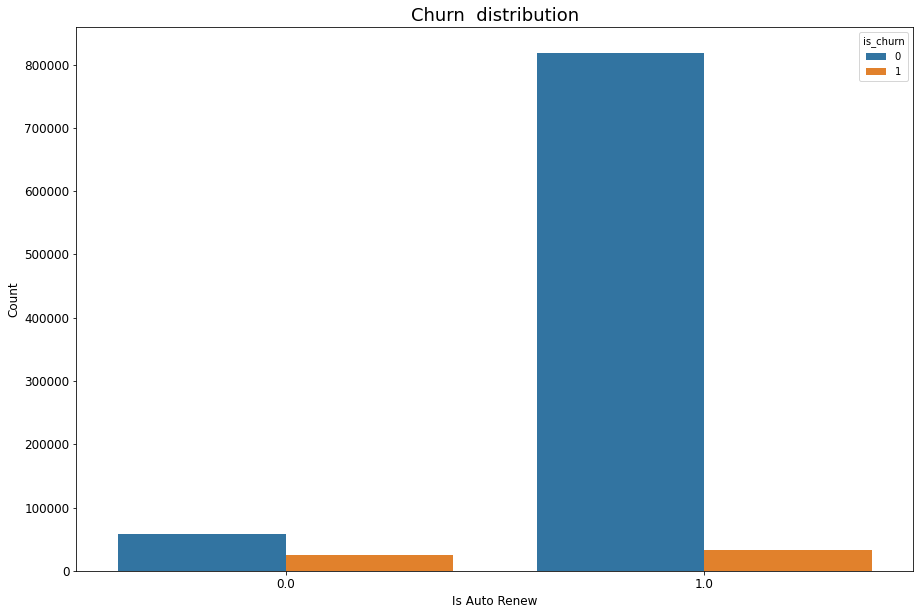

In [71]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_mt, x='is_auto_renew', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Is Auto Renew', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

In [72]:
# Replace Nan Values 
train_mt.is_auto_renew = train_mt.is_auto_renew.fillna(2)

* Transaction Date

In [73]:
train_mt['year_tr'] = train_mt['transaction_date'].dt.year.values
train_mt['month_tr'] = train_mt['transaction_date'].dt.month.values

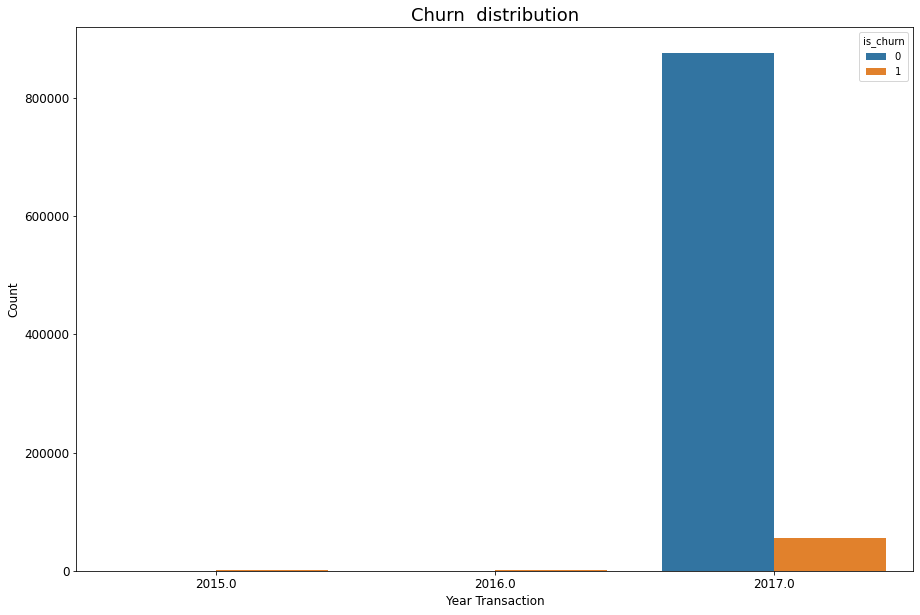

In [74]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_mt, x='year_tr', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Year Transaction', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

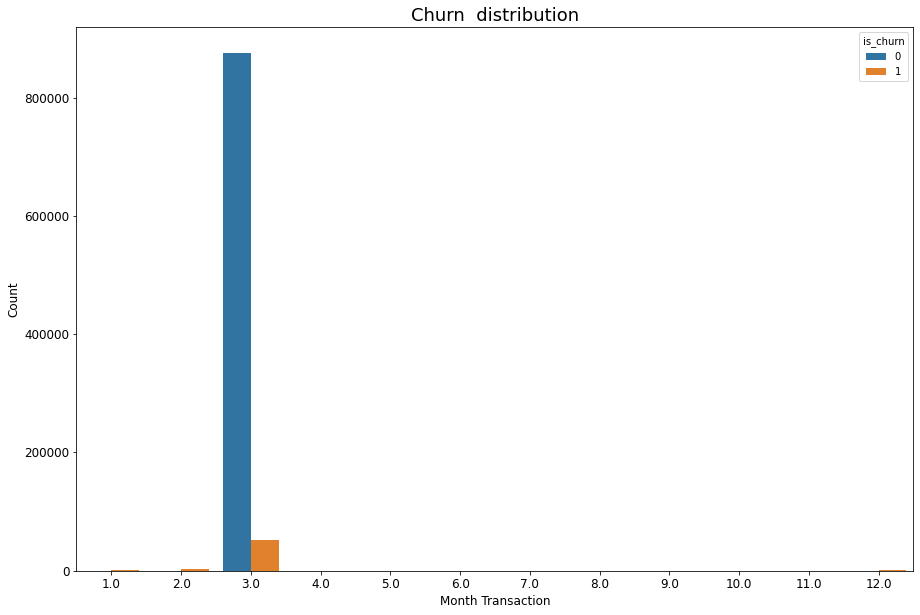

In [75]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_mt, x='month_tr', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Month Transaction', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

In [76]:
# Fill nan values and update the dataframe
dates = list(train_mt.sort_values('transaction_date')['transaction_date'])
train_mt.transaction_date = train_mt.transaction_date.fillna(dates[len(dates)//2])

In [77]:
train_mt['year_tr'] = train_mt['transaction_date'].dt.year.values
train_mt['month_tr'] = train_mt['transaction_date'].dt.month.values

* Membership Expire Date

In [78]:
train_mt['membership_expire_date'] = pd.to_datetime(train_mt['membership_expire_date'], format='%Y%m%d')
train_mt['expire_year'] = train_mt['membership_expire_date'].dt.year.values
train_mt['expire_month'] = train_mt['membership_expire_date'].dt.month.values

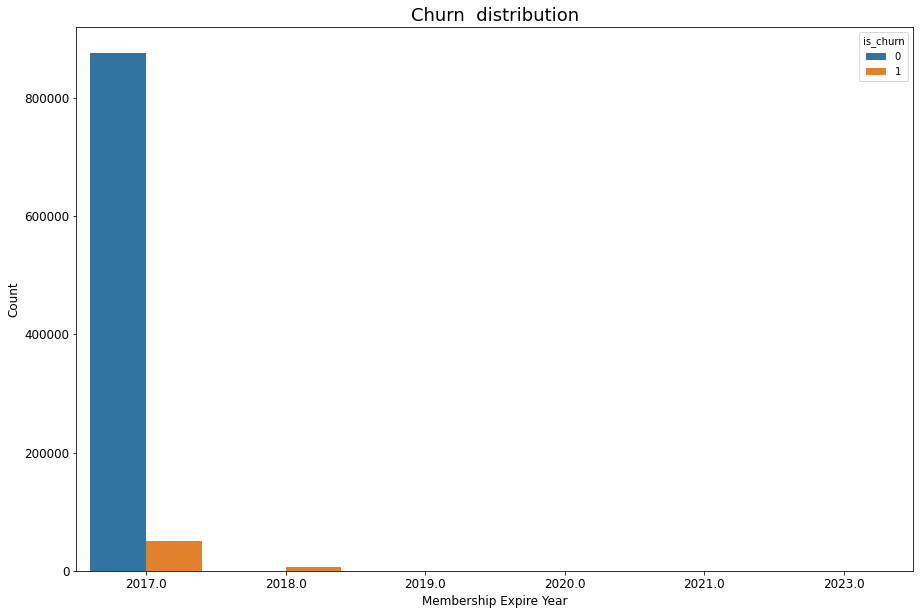

In [79]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_mt, x='expire_year', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Membership Expire Year', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

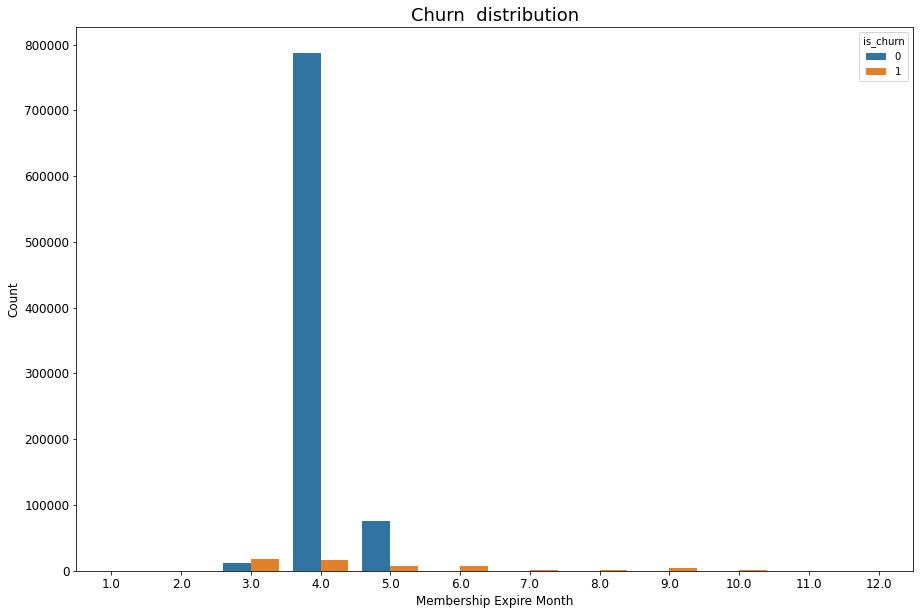

In [80]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_mt, x='expire_month', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Membership Expire Month', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

In [81]:
# Modify outliers and update dataframe
dates = list(train_mt.sort_values('membership_expire_date')['membership_expire_date'])
train_mt.membership_expire_date = train_mt.membership_expire_date.fillna(dates[len(dates)//2])

In [82]:
train_mt['expire_year'] = train_mt['membership_expire_date'].dt.year.values
train_mt['expire_month'] = train_mt['membership_expire_date'].dt.month.values

* Is Cancel

In [83]:
train_mt['is_cancel'].unique()

array([nan,  0.,  1.])

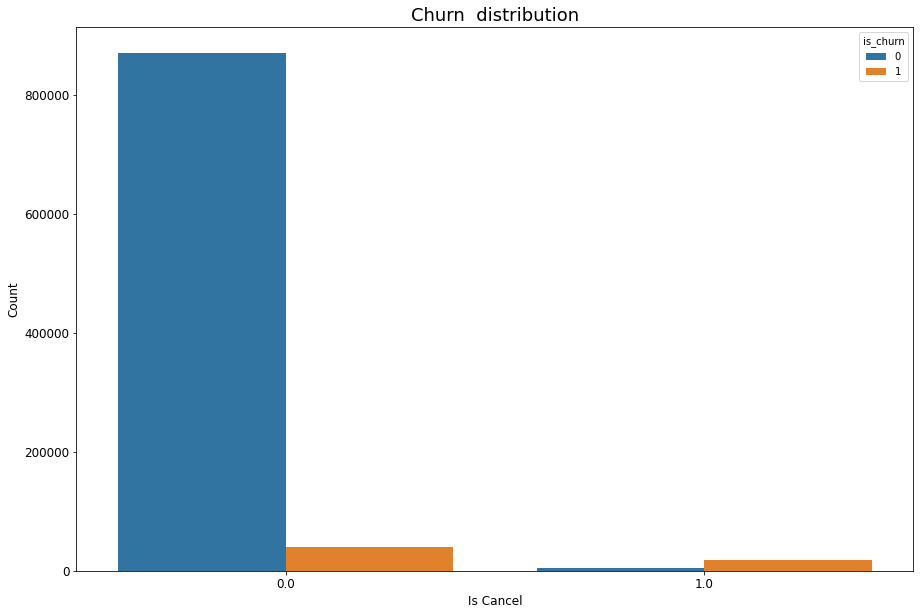

In [84]:
plt.figure(figsize=(15,10))
ax = sns.countplot(data=train_mt, x='is_cancel', hue = 'is_churn')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Is Cancel', size=12)
plt.ylabel('Count', size=12)
plt.title('Churn  distribution', size=18)
plt.show()

In [85]:
train_mt.is_cancel = train_mt.is_cancel.fillna(2)

By the end of this part, we have removed all the outliers and filled the nan values

In [86]:
train_mt.isnull().sum()

msno                      0
is_churn                  0
city                      0
gender                    0
registered_via            0
registration_init_time    0
bd_range                  0
year                      0
month                     0
weekday                   0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
year_tr                   0
month_tr                  0
expire_year               0
expire_month              0
dtype: int64

## User Logs

In [87]:
user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [88]:
user_logs.shape

(18396362, 9)

For each user, we have their daily activity; thus we will aggregate these data by taking the mean of each column 

In [89]:
user_logs = user_logs.groupby('msno',as_index=False).mean()
user_logs.drop(columns=['date'],axis=1,inplace=True)
user_logs.head()

,msno,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,3.307692,0.423077,0.384615,0.192308,18.153846,20.384615,4534.900962
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,6.161290,2.903226,2.419355,4.645161,19.000000,28.548387,6210.577161
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,1.535714,0.428571,0.535714,0.428571,17.321429,16.714286,4121.830714
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,9.857143,7.761905,4.761905,3.047619,20.761905,39.428571,7137.931333
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,3.620690,0.827586,1.344828,1.206897,16.517241,7.931034,4014.939552


In [90]:
# We will merge user_logs with our dataframe
train_mtu = pd.merge(train_mt, user_logs, on='msno', how='left')

In [91]:
train_mtu.shape

(970960, 29)

<AxesSubplot:xlabel='is_churn', ylabel='num_25'>

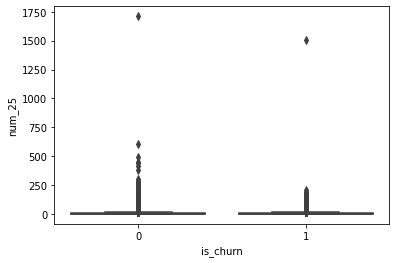

In [92]:
sns.boxplot(x='is_churn', y='num_25', data=train_mtu)

<AxesSubplot:xlabel='is_churn', ylabel='num_50'>

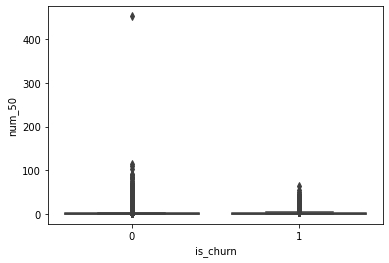

In [93]:
sns.boxplot(x='is_churn', y='num_50', data=train_mtu)

We will fill the nan values of each column by the mean value of this column

In [94]:
mean_25 = np.nanmedian(train_mtu['num_25'])
mean_50 = np.nanmedian(train_mtu['num_50'])
mean_75 = np.nanmedian(train_mtu['num_75'])
mean_985 = np.nanmedian(train_mtu['num_985'])
mean_100 = np.nanmedian(train_mtu['num_100'])
mean_unq = np.nanmedian(train_mtu['num_unq'])
mean_total = np.nanmedian(train_mtu['total_secs'])

In [95]:
train_mtu.num_25 = train_mtu.num_25.fillna(mean_25)
train_mtu.num_50 = train_mtu.num_50.fillna(mean_50)
train_mtu.num_75 = train_mtu.num_75.fillna(mean_75)
train_mtu.num_985 = train_mtu.num_985.fillna(mean_985)
train_mtu.num_100 = train_mtu.num_100.fillna(mean_100)
train_mtu.num_unq = train_mtu.num_unq.fillna(mean_unq)
train_mtu.total_secs = train_mtu.total_secs.fillna(mean_total)

We also observe that there are a lot of outliers, this time we will update the outliers that are superior to the quantile(0.9999) by the quantile(0.9999)

In [96]:
quantile_25 = train_mtu.num_25.quantile(0.9999)
quantile_50 = train_mtu.num_50.quantile(0.9999)
quantile_75 = train_mtu.num_75.quantile(0.9999)
quantile_985 = train_mtu.num_985.quantile(0.9999)
quantile_100 = train_mtu.num_100.quantile(0.9999)
quantile_unq = train_mtu.num_unq.quantile(0.9999)
quantile_total = train_mtu.total_secs.quantile(0.9999)

In [97]:
train_mtu['num_25'] = train_mtu['num_25'].apply(lambda x: x if (x <= quantile_25) else quantile_25)
train_mtu['num_50'] = train_mtu['num_50'].apply(lambda x: x if (x <= quantile_50) else quantile_50)
train_mtu['num_75'] = train_mtu['num_75'].apply(lambda x: x if (x <= quantile_75) else quantile_75)
train_mtu['num_985'] = train_mtu['num_985'].apply(lambda x: x if (x <= quantile_985) else quantile_985)
train_mtu['num_100'] = train_mtu['num_100'].apply(lambda x: x if (x <= quantile_100) else quantile_100)
train_mtu['num_unq'] = train_mtu['num_unq'].apply(lambda x: x if (x <= quantile_unq) else quantile_unq)
train_mtu['total_secs'] = train_mtu['total_secs'].apply(lambda x: x if (x <= quantile_total) else quantile_total)

In [98]:
train_mtu.isnull().sum()

msno                      0
is_churn                  0
city                      0
gender                    0
registered_via            0
registration_init_time    0
bd_range                  0
year                      0
month                     0
weekday                   0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
year_tr                   0
month_tr                  0
expire_year               0
expire_month              0
num_25                    0
num_50                    0
num_75                    0
num_985                   0
num_100                   0
num_unq                   0
total_secs                0
dtype: int64

In [99]:
train_mtu.head()

,msno,is_churn,city,gender,registered_via,registration_init_time,bd_range,year,month,weekday,...,month_tr,expire_year,expire_month,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,1.0,3.0,2013-12-23,3,2013,12,0,...,3,2017,4,16.909091,2.090909,1.181818,0.909091,28.909091,31.636364,7327.141545
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,1.0,3.0,2013-12-23,1,2013,12,0,...,3,2017,4,0.000000,0.666667,0.333333,0.000000,4.333333,5.000000,1164.418167
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,1.0,3.0,2013-12-27,1,2013,12,4,...,3,2017,6,11.950000,2.850000,1.600000,1.100000,10.250000,21.600000,3390.523350
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,7.0,2014-01-09,7,2014,1,3,...,12,2018,1,3.454545,0.888889,0.600000,0.608696,17.454545,19.233333,4709.031167
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,2.0,7.0,2014-01-25,4,2014,1,5,...,3,2017,9,0.600000,0.466667,0.266667,0.266667,64.133333,36.533333,15992.149400


In [ ]:
train_mtu.to_csv('final_df.csv', index=False)